In [1]:
import os

In [2]:
path = r"C:\Users\blais\Documents\ML\data\weather\jena_climate_2009_2016.csv"

In [5]:
with open(path) as f:
    data = f.read()

In [7]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] 

In [8]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [9]:
print(len(lines))

420451


Parsing the data:

In [10]:
import numpy as np

In [11]:
temperature = np.zeros((len(lines),))

In [12]:
raw_data = np.zeros((len(lines),len(header)-1))

In [13]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

lets check out the plot of the temperature in degrees celsius over time. 

In [14]:
import matplotlib.pyplot as plt

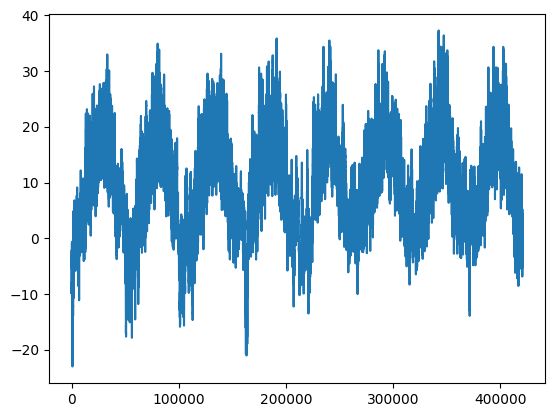

In [15]:
plt.plot(range(len(temperature)), temperature)

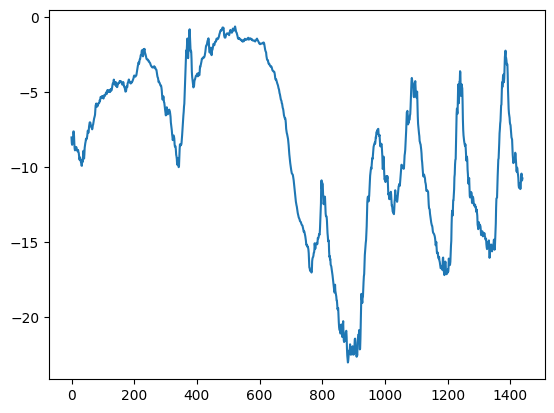

In [16]:
plt.plot(range(1440), temperature[:1440])

Computing the number of samples we'll use for each data split:

In [17]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25*len(raw_data))
num_test_samples = len(raw_data) - num_train_samples-num_val_samples

Preparing the data:
- Given data covering the previous 5 days sampled once per hour - can we predict the temperature in 24 hours
- 

In [19]:
raw_data.shape

(420451, 14)

In [20]:
# normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data/=std

Create a dataset object - that yields batches of data from past 5 days along with a target temperature 24 hours in the future. Samples in the dataset are highly redundant - sample N and N+1 will have most of their timesteps in common - would be wasteful to explicitly allocate memory for every sample. Instead, we'll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays

In [21]:
import numpy as np
from tensorflow import keras

In [22]:
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2
)

In [26]:
for inputs, targets in dummy_dataset:
    print(inputs, targets)

tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int32) tf.Tensor([3 4], shape=(2,), dtype=int32)
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int32) tf.Tensor([5 6], shape=(2,), dtype=int32)
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int32) tf.Tensor([7], shape=(1,), dtype=int32)


In [33]:
int_seq2 =  np.arange(20)

In [34]:
int_seq2

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [38]:
int_seq2[:-3]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [39]:
int_seq2[3:]

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [42]:
dummy_dataset2 = keras.utils.timeseries_dataset_from_array(
    data = int_seq2[:-3],
    sampling_rate=2,
    targets=int_seq2[6:],
    sequence_length=3,
    batch_size=2
)

In [43]:
for inputs, targets in dummy_dataset2:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 2, 4] 6
[1, 3, 5] 7
[2, 4, 6] 8
[3, 5, 7] 9
[4, 6, 8] 10
[5, 7, 9] 11
[6, 8, 10] 12
[7, 9, 11] 13
[8, 10, 12] 14
[9, 11, 13] 15
[10, 12, 14] 16
[11, 13, 15] 17
[12, 14, 16] 18


In [27]:
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
targets = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Shifted by 1 for prediction

In [30]:
keras.utils.timeseries_dataset_from_array?

Signature:
keras.utils.timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None,
)
Docstring:
Creates a dataset of sliding windows over a timeseries provided as array.

This function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
length of the sequences/windows, spacing between two sequence/windows, etc.,
to produce batches of timeseries inputs and targets.

Args:
    data: Numpy array or eager tensor
        containing consecutive data points (timesteps).
        Axis 0 is expected to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        `targets[i]` should be the target
        corresponding to the window that starts at index `i`
        (see example 2 below).
        Pass `None` if you don't have target data (in this case the dataset
 

We'll use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation and the other for testing.:
- sampling_rate = 6 - observations will be sampled at one data point per hour: we'll keep one data point out of 6 (cuz the data is recorded/sampled every 10 minutes)
- sequence-length = 120 - observations will go back 5 days
- delay = sampling_rate*(sequence_length+24-1) - the target for a sequence will be temperature 24 hours after the end of a sequence

In [31]:
raw_data.shape

(420451, 14)

In [55]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size =256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [46]:
raw_data.shape

(420451, 14)

In [47]:
temperature.shape

(420451,)

Each dataset yields a tuple (samples, targets) - where samples is a batch of 256 samples each containing 120 consecutive hours of input data. and target is the corresponding array of 256 target temperatures. Samples are randomly shuffled, so two consecutive sequences in a batch aren't necessarily temporally close:

In [56]:
for samples, targets in train_dataset:
    print("samples shape: ", samples.shape)
    print("targets shape: ", targets.shape)
    break

samples shape:  (256, 120, 14)
targets shape:  (256,)


In [57]:
for samples, targets in val_dataset:
    print("samples shape: ", samples.shape)
    print("targets shape: ", targets.shape)
    break

samples shape:  (256, 120, 14)
targets shape:  (256,)


output - ultimately a tuple

A common sense, non-machine learning baseline:

In [50]:
std

array([ 8.50510865,  8.77098361,  8.86560463,  7.08011256, 16.62877917,
        7.6012955 ,  4.14689697,  4.76961017,  2.63277288,  4.1996886 ,
       42.0392747 ,  1.53358803,  2.32305586, 85.85032063])

In [49]:
std[1]

8.770983608349871

In [51]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]
    return total_abs_err/samples_seen

In [52]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Try a basic ml model:

In [53]:
raw_data.shape[-1]

14

In [60]:
sequence_length

120

In [62]:
inputs = layers.Input(shape=[120,14])

In [63]:
inputs(train_dataset)

TypeError: 'KerasTensor' object is not callable

In [71]:
from tensorflow import keras 
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
  keras.callbacks.ModelCheckpoint("jena_dense.keras",
  save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=10,
            validation_data=val_dataset,
            callbacks=callbacks)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node functional_5_1/flatten_9_1/Reshape defined at (most recent call last):
  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1906, in _run_once

  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code

  File "C:\Users\blais\AppData\Local\Temp\ipykernel_41720\3596442197.py", line 13, in <module>

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 58, in train_step

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\ops\function.py", line 177, in _run_through_graph

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\models\functional.py", line 648, in call

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\ops\numpy.py", line 5074, in reshape

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2068, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node functional_5_1/flatten_9_1/Reshape}}]] [Op:__inference_multi_step_on_iterator_15218]

In [69]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = layers.Input(shape=[120,14])
inputs = layers.Reshape([120,14])(inputs)
# inputs = layers.Input(shape=[120,14])(inputs)
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node functional_4_1/flatten_8_1/Reshape defined at (most recent call last):
  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1906, in _run_once

  File "C:\Users\blais\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code

  File "C:\Users\blais\AppData\Local\Temp\ipykernel_41720\1033407820.py", line 15, in <module>

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 58, in train_step

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\ops\function.py", line 177, in _run_through_graph

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\models\functional.py", line 648, in call

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\ops\numpy.py", line 5074, in reshape

  File "c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2068, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node functional_4_1/flatten_8_1/Reshape}}]] [Op:__inference_multi_step_on_iterator_14508]